In [79]:
import os
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import plotly.graph_objects as go
headers = {
    'User-Agent': 'ChessDataFetcher/1.0 (ardilyuce@gmail.com)'
}

username = "ardil30"  # Chess.com username
raw_file_path = f"./data/raw/{username}_raw_games.json"
processed_json_path = f"./data/processed/{username}_games.json"
processed_csv_path = f"./data/processed/{username}_games.csv"
openings_file_path = "./data/processed/chess_openings.txt"

In [18]:
def fetch_game_archives(username):
    """
    Fetch the game archives URLs for the player.
    """
    url = f'https://api.chess.com/pub/player/{username}/games/archives'
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error fetching archives: HTTP {response.status_code}, {response.text}")
        return []
    archives = response.json().get('archives', [])
    print(f"Archives fetched: {len(archives)} archives found.")
    return archives

def fetch_games_from_archive(archive_url):
    """
    Fetch all games from a given archive URL.
    """
    response = requests.get(archive_url, headers=headers)
    if response.status_code != 200:
        print(f"Error fetching games from {archive_url}: HTTP {response.status_code}, {response.text}")
        return []
    games = response.json().get('games', [])
    return games

def fetch_all_games(username):
    """
    Fetch all games by iterating through their game archives.
    """
    all_games = []
    archives = fetch_game_archives(username)
    if not archives:
        print("No archives fetched. Ensure the username is correct or the Chess.com API is accessible.")
        return all_games

    for archive_url in archives:
        games = fetch_games_from_archive(archive_url)
        all_games.extend(games)

    return all_games

def save_to_json(data, filename):
    """
    Save data to a beautified JSON file.
    """
    print(f"Saving data to {filename}...")
    if not data:
        print("No data to save. The file will not be updated.")
        return

    with open(filename, "w") as file:
        json.dump(data, file, indent=4)
    print(f"Data saved successfully to {filename}. File size: {os.path.getsize(filename)} bytes")

# Main code

# Ensure the raw data directory exists
os.makedirs(os.path.dirname(raw_file_path), exist_ok=True)

# Fetch new games
all_games = fetch_all_games(username)

# Save fetched data
save_to_json(all_games, raw_file_path)

Archives fetched: 27 archives found.
Saving data to ./data/raw/ardil30_raw_games.json...
Data saved successfully to ./data/raw/ardil30_raw_games.json. File size: 7609450 bytes


In [19]:
def load_openings(file_path):
    """
    Load a list of main openings from a text file.
    """
    # Ensure the file exists
    if not os.path.exists(file_path):
        with open(file_path, "w") as file:
            pass  # Create an empty file

    with open(file_path, "r") as file:
        return [line.strip().lower() for line in file if line.strip()]

def add_opening_to_file(file_path, opening):
    """
    Add a new opening to the openings file if it doesn't already exist.
    """
    openings = load_openings(file_path)
    opening_lower = opening.lower()
    if opening_lower not in openings:
        with open(file_path, "a") as file:
            file.write(opening + "\n")
        print(f"New opening added to {file_path}: {opening}")

def split_pgn(pgn):
    """
    Split PGN into metadata (headers) and move list.
    Format the metadata as a dictionary for better readability.
    """
    if not pgn:
        return {"Information": {}, "Moves": "No Moves available"}

    try:
        parts = pgn.split("\n\n")  # Split PGN into headers and moves
        metadata_lines = parts[0].strip().split("\n")  # Split headers by lines
        moves = parts[1].strip() if len(parts) > 1 else "No Moves available"  # Moves section

        # Convert metadata lines to a dictionary
        metadata = {}
        for line in metadata_lines:
            if line.startswith("[") and line.endswith("]"):
                key_value = line[1:-1].split(" ", 1)  # Remove brackets and split by the first space
                if len(key_value) == 2:
                    key, value = key_value
                    metadata[key] = value.strip('"')  # Remove quotes around values

        return {"Information": metadata, "Moves": moves}
    except IndexError:
        return {"Information": {}, "Moves": "Invalid PGN format"}

def determine_game_result(game, username):
    """
    Determine the result of the game for the given player.
    """
    white_player = game.get("white", {}).get("username", "").lower()
    black_player = game.get("black", {}).get("username", "").lower()
    white_result = game.get("white", {}).get("result", "").lower()
    black_result = game.get("black", {}).get("result", "").lower()

    if username.lower() == white_player.strip().lower():
        if white_result == "win":
            return "Win"
        elif white_result in ["checkmated", "timeout", "resigned", "abandoned"]:
            return "Loss"
        elif white_result in ["stalemate", "draw", "insufficient material", "insufficient", "repetition", "agreed", "50move", "timevsinsufficient"]:
            return "Draw"
    elif username.lower() == black_player.strip().lower():
        if black_result == "win":
            return "Win"
        elif black_result in ["checkmated", "timeout", "resigned", "abandoned"]:
            return "Loss"
        elif black_result in ["stalemate", "draw", "insufficient material", "insufficient", "repetition", "agreed", "50move", "timevsinsufficient"]:
            return "Draw"
    return "Unknown"

def extract_opening_from_pgn(metadata):
    """
    Extract the opening name from the PGN metadata (based on Chess.com opening URL).
    Removes any single quotes from the opening name.
    """
    eco_url = metadata.get("ECOUrl", "")
    if eco_url and "chess.com/openings/" in eco_url:
        opening_name = eco_url.split("chess.com/openings/")[-1].replace("-", " ").capitalize()
        opening_name = opening_name.replace("'", "")  # Remove any single quotes
        return opening_name
    return "Unknown"

def process_game_data(all_games, username, openings_file):
    """
    Beautify and structure game data with main openings and variations.
    """
    def unix_to_readable(unix_time):
        return datetime.fromtimestamp(unix_time, timezone.utc).strftime('%Y-%m-%d %H:%M:%S')

    # Load main openings from the text file
    main_openings = load_openings(openings_file)

    game_list = []
    for game in all_games:
        pgn_split = split_pgn(game.get("pgn", ""))
        metadata = pgn_split.get("Information", {})

        # Extract opening name from the ECO URL
        opening_name = extract_opening_from_pgn(metadata)

        # Determine game result
        game_result = determine_game_result(game, username)

        # Determine main opening and variation
        main_opening = "Unknown"
        variation = opening_name

        for main in main_openings:
            if opening_name.lower().find(main.lower()) != -1:  # Compare with main openings
                main_opening = main
                variation = opening_name.strip().capitalize()
                break

        # Add unknown opening to the openings file
        if main_opening == "Unknown" and opening_name != "Unknown":
            add_opening_to_file(openings_file, opening_name)
            main_opening = opening_name
            variation = "Unknown"

        game_entry = {
            "Game URL": game.get("url", ""),
            "Time Class": game.get("time_class", "N/A").capitalize(),
            "End Time": unix_to_readable(game.get("end_time", 0)),
            "White Player": game.get("white", {}).get("username", "Unknown"),
            "White Rating": game.get("white", {}).get("rating", "N/A"),
            "Black Player": game.get("black", {}).get("username", "Unknown"),
            "Black Rating": game.get("black", {}).get("rating", "N/A"),
            "Result": game_result,  # Processed as "Win", "Loss", or "Draw"
            "Main Opening": main_opening,  # Main opening from the text file
            "Variation": variation,  # Remaining part as variation
            "Information": pgn_split["Information"],  # Metadata
            "Moves": pgn_split["Moves"]  # Actual moves
        }
        if(game.get("rules", {}) == "chess"):
            game_list.append(game_entry)
    return game_list

def save_to_csv(data, filename):
    """
    Save data to a CSV file.
    """
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename} (CSV format)")

def save_to_json(data, filename):
    """
    Save data to a beautified JSON file.
    """
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)
    print(f"Data saved to {filename} (JSON format)")

# Main code

# Ensure the processed data directory exists
os.makedirs("./data/processed", exist_ok=True)

# Load raw data
with open(raw_file_path, "r") as file:
    raw_data = json.load(file)

# Process data
processed_data = process_game_data(raw_data, username, openings_file_path)

# Save processed data
save_to_json(processed_data, processed_json_path)
save_to_csv(processed_data, processed_csv_path)


Data saved to ./data/processed/ardil30_games.json (JSON format)
Data saved to ./data/processed/ardil30_games.csv (CSV format)


In [20]:
def load_processed_data(file_path):
    """
    Load the processed game data from a JSON file.
    """
    return pd.read_json(file_path)

data = load_processed_data(processed_json_path)

In [21]:
def analyze_openings(data):
    """
    Analyze most frequent main openings and their win rates.
    """
    # Filter out games with fewer than 10 games
    opening_stats_with_win = data[['Main Opening', 'Result']]

    # Group by Opening and Win/Draw/Loss result
    opening_stats_with_ranks = opening_stats_with_win.groupby(['Main Opening', 'Result']).size().unstack(fill_value=0)

    # Add the total number of games played for each opening
    opening_stats_with_ranks['Total'] = opening_stats_with_ranks.sum(axis=1)

    # Drop openings with fewer than 10 games
    opening_stats_with_ranks = opening_stats_with_ranks[opening_stats_with_ranks['Total'] >= 10]

    # Calculate the win rate for each opening
    opening_stats_with_ranks['Win Rate'] = (opening_stats_with_ranks['Win'] / opening_stats_with_ranks['Total'])

    # Sort by the total number of games played (descending order)
    opening_stats_with_ranks = opening_stats_with_ranks.sort_values(by='Total', ascending=False)

    # Select top 10 most played openings
    top_10_openings = opening_stats_with_ranks.head(10)

    # Round the 'Win Rate' to 3 decimal places
    top_10_openings.loc[:, 'Win Rate'] = top_10_openings['Win Rate'].round(3)

    return top_10_openings

# Analyze main openings
print("Analyzing main openings...")
top_10_openings = analyze_openings(data)

# Display the top 10 openings as a DataFrame
top_10_openings


Analyzing main openings...


Result,Draw,Loss,Win,Total,Win Rate
Main Opening,,,,,
pirc,17,164,174,355,0.490
english,17,138,197,352,0.560
reti,7,101,138,246,0.561
modern defense,11,76,93,180,0.517
caro kann,4,68,80,152,0.526
kings indian,3,32,47,82,0.573
sicilian,1,36,36,73,0.493
giuoco piano,2,29,37,68,0.544
indian game,4,22,40,66,0.606


/tmp/ipykernel_82331/2475887959.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  differential_stats = data.groupby("Rating Differential Bin").apply(
/tmp/ipykernel_82331/2475887959.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  differential_stats = data.groupby("Rating Differential Bin").apply(


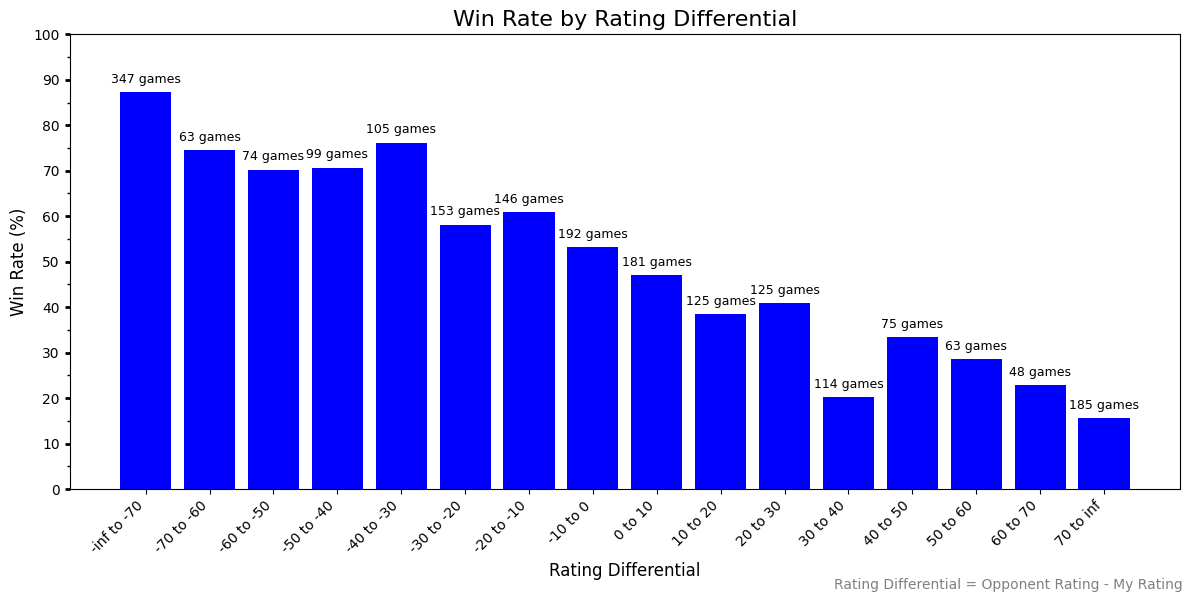

In [48]:
def calculate_rating_differential(row, username):
    """
    Calculate rating differential for the player (opponent_rating - my_rating).
    """
    player_rating = (
        row["White Rating"] if row["White Player"].lower() == username.lower()
        else row["Black Rating"]
    )
    opponent_rating = (
        row["Black Rating"] if row["White Player"].lower() == username.lower()
        else row["White Rating"]
    )
    return opponent_rating - player_rating

def group_by_rating_differential(data, username):
    """
    Group games by smaller rating differentials (10-point intervals) and calculate win rates.
    """
    # Calculate rating differential for each game
    data["Rating Differential"] = data.apply(
        lambda row: calculate_rating_differential(row, username), axis=1
    )

    # Define rating differential bins
    bins = [-float("inf")] + list(range(-70, 71, 10)) + [float("inf")]
    labels = [f"{bins[i]} to {bins[i+1]}" for i in range(len(bins) - 1)]

    # Categorize each game into a bin
    data["Rating Differential Bin"] = pd.cut(
        data["Rating Differential"], bins=bins, labels=labels, right=False
    )

    # Calculate win rate for each bin
    differential_stats = data.groupby("Rating Differential Bin").apply(
        lambda x: pd.Series({
            "Games Played": len(x),
            "Win Rate": (x["Result"] == "Win").mean() * 100
        })
    )

    return differential_stats

def plot_stats(stats, title, xlabel, ylabel):
    """
    Plot win rates based on calculated stats.
    """
    plt.figure(figsize=(12, 6))
    bars = plt.bar(stats.index.astype(str), stats["Win Rate"], color="blue")

    # Annotate each bar with the number of games played
    for bar, games in zip(bars, stats["Games Played"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 2,
            f"{int(games)} games",
            ha="center",
            fontsize=9
        )

    # Add a note to the graph
    plt.figtext(
        0.99, 0.01, 
        "Rating Differential = Opponent Rating - My Rating", 
        horizontalalignment="right", fontsize=10, color="gray"
    )

    # Set chart limits and labels
    plt.ylim(0, 100)  # Y-axis from 0 to 100%
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha="right")
    
    # Customize y-axis ticks
    ax = plt.gca()  # Get the current axis
    ax.yaxis.set_major_locator(MultipleLocator(10))  
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))  
    
    # Customize tick lines (major and minor)
    ax.tick_params(axis="y", which="major", width=2)  # Thicker major ticks
    ax.tick_params(axis="y", which="minor", width=1)  # Thinner minor ticks
    
    plt.tight_layout()

    # Show the plot instead of saving it
    plt.show()

# Load processed data


differential_stats = group_by_rating_differential(data, username)

plot_stats(
    differential_stats,
    "Win Rate by Rating Differential",
    "Rating Differential",
    "Win Rate (%)"
)


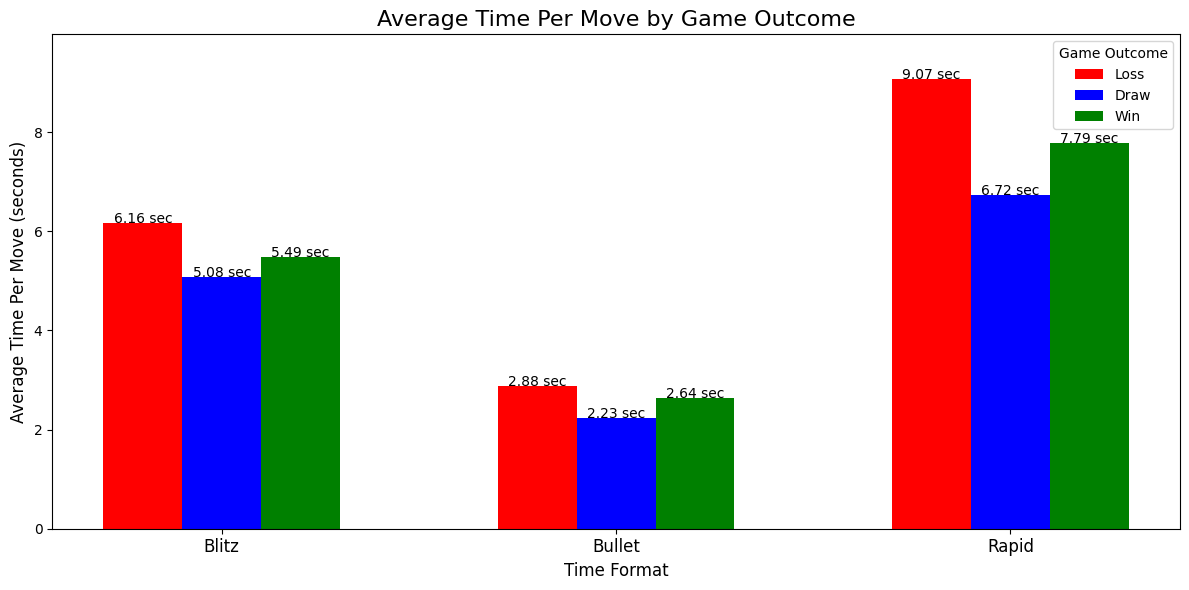

In [51]:
def to_seconds(time_str):
    """
    Convert a time string in the format hours:minutes:seconds to seconds.
    """
    parts = list(map(float, time_str.split(":")))
    if len(parts) == 2:  # Format: mm:ss
        return parts[0] * 60 + parts[1]
    elif len(parts) == 3:  # Format: hh:mm:ss
        return parts[0] * 3600 + parts[1] * 60 + parts[2]

def extract_time_per_move(moves, player_color):
    """
    Extract and calculate the average time per move for a player (White or Black).
    """
    if player_color.lower() not in ["white", "black"]:
        raise ValueError("player_color must be 'white' or 'black'.")

    # Extract times based on the player's moves
    if player_color.lower() == "white":
        times = re.findall(r"[^\.]\.\s[^\[]+\[%clk\s([0-9:.]+)\]", moves)
    elif player_color.lower() == "black":
        times = re.findall(r"\.\.\.\s[^\[]+\[%clk\s([0-9:.]+)\]", moves)

    if len(times) <= 1:  # Not enough data to calculate time per move
        return None

    # Convert times into seconds
    times_in_seconds = list(map(to_seconds, times))

    # Calculate time differences (time per move)
    time_diffs = [
        times_in_seconds[i] - times_in_seconds[i + 1]
        for i in range(len(times_in_seconds) - 1)
        if times_in_seconds[i] > times_in_seconds[i + 1]  # Ignore anomalies
    ]
    return sum(time_diffs) / len(time_diffs) if time_diffs else None

def analyze_time_management(data, username):
    """
    Analyze time management for each time format and game outcome, focusing on the player's moves.
    """
    time_data = []

    for _, row in data.iterrows():
        if row["Time Class"].lower() == "daily":
            continue  # Exclude Daily games

        # Determine player's color
        player_color = "white" if row["White Player"].lower() == username.lower() else "black"
        
        # Extract average time per move for the player
        avg_time_per_move = extract_time_per_move(row["Moves"], player_color)

        if avg_time_per_move is not None:
            time_data.append({
                "Time Class": row["Time Class"],
                "Result": row["Result"],
                "Average Time Per Move": avg_time_per_move
            })

    # Convert to DataFrame
    time_data = pd.DataFrame(time_data)

    # Group by Time Class and Result
    grouped_data = time_data.groupby(["Time Class", "Result"]).agg({
        "Average Time Per Move": "mean"
    }).reset_index()

    return grouped_data

def plot_time_management(data):
    """
    Plot time management for all time formats in a single graph.
    """
    time_classes = data["Time Class"].unique()
    result_order = ["Loss", "Draw", "Win"]  # Desired order for results

    # Prepare data for plotting
    bar_width = 0.2
    x_positions = {time_class: i for i, time_class in enumerate(time_classes)}
    offset_map = {result: (idx - 1) * bar_width for idx, result in enumerate(result_order)}

    # Create plot
    plt.figure(figsize=(12, 6))
    for result in result_order:
        subset = data[data["Result"] == result]
        x_values = [x_positions[time_class] + offset_map[result] for time_class in subset["Time Class"]]
        y_values = subset["Average Time Per Move"]
        bars = plt.bar(
            x_values, y_values, bar_width, label=result,
            color="green" if result == "Win" else "red" if result == "Loss" else "blue"
        )

        # Annotate bars
        for bar in bars:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{bar.get_height():.2f} sec",
                ha="center",
                fontsize=10
            )

    # Configure plot aesthetics
    plt.xticks(
        [x_positions[time_class] for time_class in time_classes],
        time_classes, fontsize=12
    )
    plt.ylim(0, max(data["Average Time Per Move"]) * 1.1)  # Add some padding
    plt.title("Average Time Per Move by Game Outcome", fontsize=16)
    plt.xlabel("Time Format", fontsize=12)
    plt.ylabel("Average Time Per Move (seconds)", fontsize=12)
    plt.legend(title="Game Outcome", fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

time_management_stats = analyze_time_management(data, username)

plot_time_management(time_management_stats)


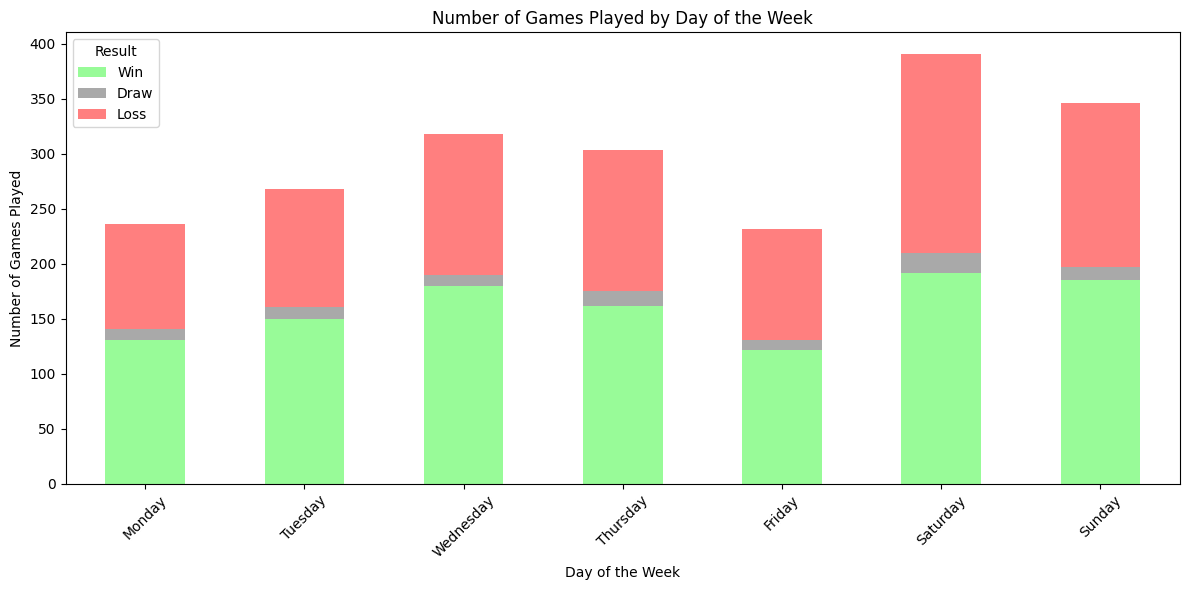

In [52]:
# Ensure the 'End Time' column is in datetime format
data['End Time'] = pd.to_datetime(data['End Time'])

# Extract the day of the week
data['day_of_week'] = data['End Time'].dt.day_name()

# Categorize results into win, loss, or draw
def map_result_to_category(result):
    if 'Win' in result:
        return 'Win'
    elif 'Loss' in result:
        return 'Loss'
    elif 'Draw' in result:
        return 'Draw'
    else:
        return 'Other'

data['Result Category'] = data['Result'].apply(map_result_to_category)

# Group data by day of the week and result category
result_by_day = data.groupby(['day_of_week', 'Result Category']).size().unstack(fill_value=0)

# Reorder the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
result_by_day = result_by_day.reindex(day_order)

# Define color shades
color_map = {
    'Win': '#98fb98',   # Pale green
    'Draw': '#a9a9a9',  # Dark gray
    'Loss': '#ff7f7f'   # Light red
}

# Plot the stacked bar chart
result_by_day[['Win', 'Draw', 'Loss']].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[color_map['Win'], color_map['Draw'], color_map['Loss']]
)

# Add title and labels
plt.title('Number of Games Played by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Games Played')
plt.xticks(rotation=45)
plt.legend(title='Result')
plt.tight_layout()

# Show the plot instead of saving it
plt.show()


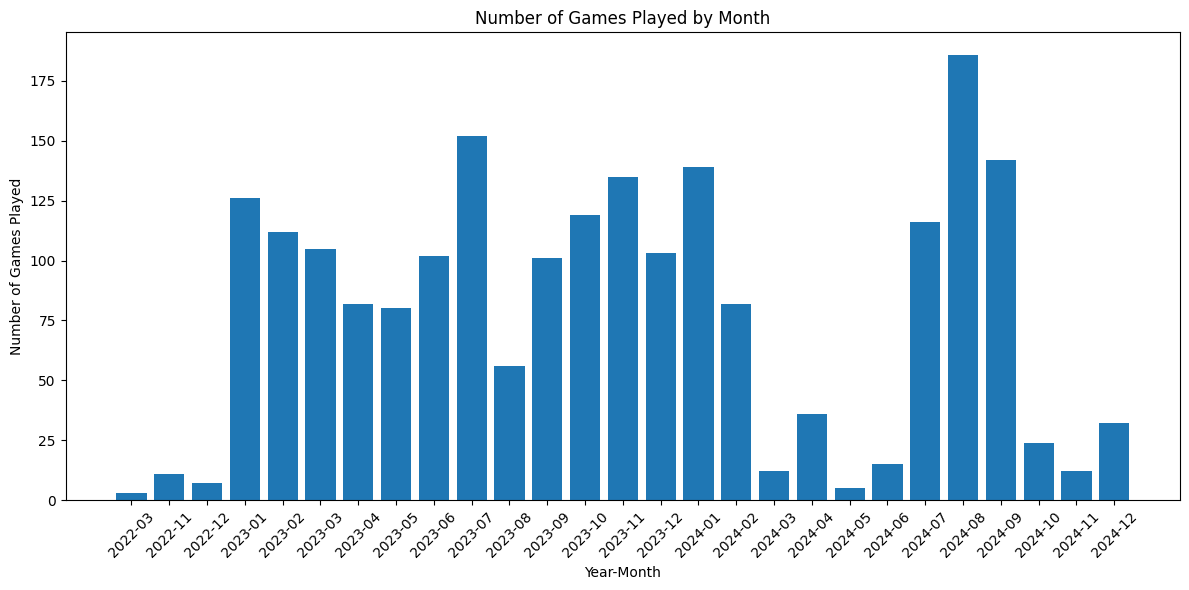

In [53]:
# Extract year and month
data['year_month'] = data['End Time'].dt.to_period('M')

# Count the number of games per year-month
games_by_month = data['year_month'].value_counts().sort_index()

# Convert to DataFrame for better handling
games_by_month_df = games_by_month.reset_index()
games_by_month_df.columns = ['Year-Month', 'Game Count']

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(games_by_month_df['Year-Month'].astype(str), games_by_month_df['Game Count'], width=0.8)
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Number of Games Played')
plt.title('Number of Games Played by Month')
plt.tight_layout()

# Show the plot instead of saving it
plt.show()


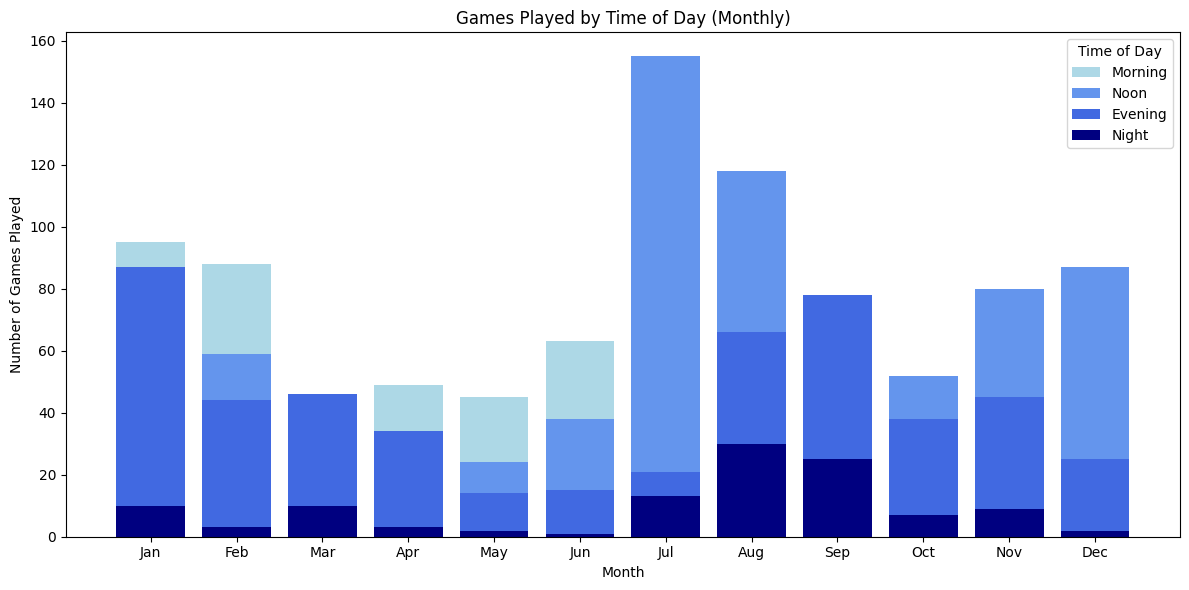

In [54]:
# Extract the month and categorize hours into time zones
data['month'] = data['End Time'].dt.month

def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['time_of_day'] = data['End Time'].dt.hour.apply(categorize_time)

# Group by month and time of day
games_by_time_of_day = data.groupby(['month', 'time_of_day']).size().reset_index(name='Game Count')

# Map time zones to shades of blue
color_map = {
    'Morning': '#add8e6',  # Light blue
    'Noon': '#6495ed',     # Cornflower blue
    'Evening': '#4169e1',  # Royal blue
    'Night': '#000080'     # Navy blue
}

# Plot the histogram
plt.figure(figsize=(12, 6))
for time_of_day, color in color_map.items():
    subset = games_by_time_of_day[games_by_time_of_day['time_of_day'] == time_of_day]
    plt.bar(subset['month'], subset['Game Count'], color=color, label=time_of_day, width=0.8)

# Add labels and legend
plt.xlabel('Month')
plt.ylabel('Number of Games Played')
plt.title('Games Played by Time of Day (Monthly)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Time of Day')
plt.tight_layout()

# Show the plot instead of saving it
plt.show()


In [55]:
# Ensure the 'Result' column exists
if 'Result' not in data.columns:
    raise ValueError("The 'Result' column is missing from the dataset.")

# Map results to streak types
def map_result_to_streak(result):
    if 'Win' in result:
        return 'Win'
    elif 'Loss' in result:
        return 'Loss'
    elif 'Draw' in result:
        return 'Draw'
    else:
        return None

data['streak_type'] = data['Result'].apply(map_result_to_streak)

# Ensure streaks are sorted by game order (assuming games are in chronological order)
# If not, sort by 'End Time' or relevant time column
data = data.sort_values('End Time')

# Calculate streaks
longest_streaks = {'Win': 0, 'Loss': 0, 'Draw': 0}
current_streak = {'type': None, 'count': 0}

for streak in data['streak_type']:
    if streak == current_streak['type']:
        current_streak['count'] += 1
    else:
        if current_streak['type']:
            longest_streaks[current_streak['type']] = max(
                longest_streaks[current_streak['type']],
                current_streak['count']
            )
        current_streak['type'] = streak
        current_streak['count'] = 1

# Handle the final streak
if current_streak['type']:
    longest_streaks[current_streak['type']] = max(
        longest_streaks[current_streak['type']],
        current_streak['count']
    )

print("Longest Streaks:")
for streak_type, streak_length in longest_streaks.items():
    print(f"{streak_type}: {streak_length} games")

Longest Streaks:
Win: 21 games
Loss: 10 games
Draw: 2 games


In [ ]:
import pandas as pd

def prepare_trend_data(data, username, window_size=5):
    """
    Prepare data for trend analysis by extracting relevant columns and applying smoothing.
    """
    # Convert end time to datetime
    data['End Time'] = pd.to_datetime(data['End Time'])

    # Add player rating column
    data['Player Rating'] = data.apply(
        lambda row: row['White Rating'] if row['White Player'] == username else row['Black Rating'], axis=1
    )

    # Add opponent rating column
    data['Opponent Rating'] = data.apply(
        lambda row: row['Black Rating'] if row['White Player'] == username else row['White Rating'], axis=1
    )

    # Sort by time
    data = data.sort_values('End Time')

    # Apply moving average to smooth ratings
    data['Smoothed Rating'] = data.groupby('Time Class')['Player Rating'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

    return data[['End Time', 'Time Class', 'Player Rating', 'Smoothed Rating', 'Opponent Rating']]

def plot_time_control(trend_data, time_class):
    """
    Plot smoothed rating trends for a specific time control using Plotly.
    """
    subset = trend_data[trend_data['Time Class'] == time_class]

    # Debugging: Check if subset has data
    if subset.empty:
        print(f"No data found for time class: {time_class}")
        return

    # Create a Plotly figure
    fig = go.Figure()

    # Add the smoothed rating as a line plot with markers
    fig.add_trace(
        go.Scatter(
            x=subset['End Time'],
            y=subset['Smoothed Rating'],
            mode='lines+markers',  # Lines and markers for individual points
            marker=dict(color='skyblue', size=5),
            hovertemplate='<br>'.join([
                'Rating: %{y}',
                'Date: %{x}'
            ]),
            name=f"{time_class.capitalize()} Rating"
        )
    )

    # Update layout with title and labels
    fig.update_layout(
        title_text=f"{time_class.capitalize()} Rating Trends Over Time (Smoothed)",
        xaxis=dict(
            title='Date',
            type='date',
            rangeslider=dict(visible=True),
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            showspikes=True,
            spikecolor="purple",
            spikesnap="cursor",
            spikemode="across"
        ),
        yaxis=dict(
            title='Rating',
            showspikes=True,
            spikecolor="orange",
            spikethickness=2
        ),
        plot_bgcolor='rgba(255, 255, 255, 0.8)',
        paper_bgcolor='rgba(255, 255, 255, 0.8)'
    )

    # Show the plot
    fig.show()

# Main code
# Assuming 'data' is already loaded with your dataset and 'username' is provided
# Prepare trend data with smoothing (less smoothing with window size 5)
trend_data = prepare_trend_data(data, username, window_size=5)

# Plot rating trends for each time control
plot_time_control(trend_data, "Blitz")
plot_time_control(trend_data, "Bullet")
plot_time_control(trend_data, "Rapid")


In [ ]:
# Extract the hour from 'End Time'
data['hour'] = data['End Time'].dt.hour

# Categorize hours into time zones
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['time_of_day'] = data['hour'].apply(categorize_time)

# Determine if the game was a win
data['is_win'] = data['Result'].str.contains('Win', case=False)

# Group by time of day and calculate win rate and match count
stats_by_time_of_day = data.groupby('time_of_day').agg(
    matches_played=('is_win', 'size'),
    win_rate=('is_win', 'mean')
).reset_index()

# Define the custom sort order
time_of_day_order = ['Morning', 'Noon', 'Evening', 'Night']
stats_by_time_of_day['time_of_day'] = pd.Categorical(
    stats_by_time_of_day['time_of_day'], 
    categories=time_of_day_order, 
    ordered=True
)

# Sort the DataFrame
stats_by_time_of_day = stats_by_time_of_day.sort_values('time_of_day')

# Display the results directly in the notebook
stats_by_time_of_day['win_rate'] = stats_by_time_of_day['win_rate'].apply(lambda x: f"{x:.2%}")
stats_by_time_of_day


,time_of_day,matches_played,win_rate
1,Morning,657,49.92%
3,Noon,810,54.44%
0,Evening,513,57.50%
2,Night,115,50.43%
